# TP NLP — Seq2Seq (LSTM) : inversion de séquences (Master IA)

Ce notebook est un **TP complet** (avec rappels et explications) pour comprendre et implémenter un modèle **Seq2Seq** (Encodeur–Décodeur) basé sur **LSTM**.

## Objectifs
À la fin du TP, vous saurez capable de:
- construire un dataset jouet de **séquences d’entiers**,
- mettre en place un **vocabulaire** avec `PAD`, `SOS`, `EOS`,
- implémenter un **encodeur LSTM** et un **décodeur LSTM**,
- entraîner avec **teacher forcing**,
- évaluer un modèle **token par token**,
- analyser les **limites** d’un Seq2Seq **sans attention**.

> Problème :  
> Entrée `x = [a, b, c, d]` → Sortie `y = [d, c, b, a]` (inversion)
> 
"L’inversion de séquence est le plus petit problème qui oblige un modèle Seq2Seq à apprendre une représentation globale, ordonnée et exploitable de la séquence d’entrée."


---

## 0) Pré-requis & rappels rapides

### RNN / LSTM en 1 minute
Un réseau récurrent traite une séquence pas à pas et maintient un **état caché**.  
LSTM améliore la capacité à apprendre des dépendances longues grâce à une **mémoire** et des **portes** (gates).

### Seq2Seq (encodeur–décodeur)
- **Encodeur** : lit la séquence source et produit un état final `(h, c)` (pour LSTM).
- **Décodeur** : génère la séquence cible **token par token** en partant de `SOS`, jusqu’à produire `EOS`.

### Teacher Forcing
Pendant l’entraînement, on fournit au décodeur le **vrai token précédent** (cible) au lieu du token prédit.  
Cela accélère l’apprentissage, mais introduit un **exposure bias** (différence train vs inference).


In [1]:
# Si besoin, installez PyTorch via votre environnement (conda/pip).
# Ce notebook suppose que torch est déjà disponible.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

---

## 1) Paramètres du TP

Nous utilisons un vocabulaire d'entiers :
- tokens "réels" : `1..V` (ex: 1 à 20)
- tokens spéciaux :
  - `PAD` : padding pour aligner les tailles
  - `SOS` : token de démarrage du décodeur
  - `EOS` : token de fin de séquence

> Important :  
> Les entrées et sorties ont des longueurs variables, donc on **pad** dans un batch.


In [2]:
# Hyperparamètres (vous pouvez ajuster)
V = 20                 # taille du "vocabulaire réel" (entiers 1..V)
MIN_LEN = 3            # longueur minimale d'une séquence
MAX_LEN = 12           # longueur maximale d'une séquence

TRAIN_SIZE = 8000
VALID_SIZE = 1000
TEST_SIZE  = 1000

BATCH_SIZE = 64

EMBED_DIM  = 64
HIDDEN_DIM = 128
NUM_LAYERS = 1
DROPOUT    = 0.0

EPOCHS = 10
LR = 1e-3

TEACHER_FORCING_RATIO = 0.7  # proba d'utiliser la vraie cible précédente pendant training


---

## 2) Vocabulaire et encodage

On définit les IDs des tokens spéciaux, puis on réserve les IDs `1..V` pour les tokens "réels".


In [3]:
PAD = 0
SOS = V + 1
EOS = V + 2

VOCAB_SIZE = V + 3  # [0..V] + SOS + EOS => total V+3

PAD, SOS, EOS, VOCAB_SIZE


(0, 21, 22, 23)

---

## 3) Génération du dataset (inversion de séquence)

Chaque exemple :
- source : séquence aléatoire d'entiers `1..V`
- target : `SOS + reversed(source) + EOS`

On inclut explicitement `SOS` et `EOS` côté cible.


In [4]:
def generate_pair(min_len=MIN_LEN, max_len=MAX_LEN, v=V):
    L = random.randint(min_len, max_len)
    src = [random.randint(1, v) for _ in range(L)]
    tgt = [SOS] + list(reversed(src)) + [EOS]
    return src, tgt

# Exemple
for _ in range(3):
    s, t = generate_pair()
    print("src:", s)
    print("tgt:", t)
    print()


src: [1, 9, 8, 8]
tgt: [21, 8, 8, 9, 1, 22]

src: [4, 18, 3, 19, 14]
tgt: [21, 14, 19, 3, 18, 4, 22]

src: [1, 3, 7]
tgt: [21, 7, 3, 1, 22]



---

## 4) Dataset + padding + collate_fn

### Pourquoi un `collate_fn` ?
Dans un batch, les séquences n'ont pas la même longueur. On va :
- padder `src` à `max_src_len` dans le batch
- padder `tgt` à `max_tgt_len` dans le batch

On crée aussi :
- `tgt_in` : entrée du décodeur (tgt sans le dernier token)
- `tgt_out`: sortie attendue (tgt sans le premier token)

Ainsi, on apprend à prédire le token suivant.


In [5]:
class ReverseSeqDataset(Dataset):
    def __init__(self, n):
        self.data = [generate_pair() for _ in range(n)]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def pad_sequences(seqs, pad_value=PAD):
    max_len = max(len(s) for s in seqs)
    padded = []
    lengths = []
    for s in seqs:
        lengths.append(len(s))
        padded.append(s + [pad_value]*(max_len - len(s)))
    return torch.tensor(padded, dtype=torch.long), torch.tensor(lengths, dtype=torch.long)

def collate_fn(batch):
    src_seqs = [b[0] for b in batch]
    tgt_seqs = [b[1] for b in batch]

    src, src_len = pad_sequences(src_seqs, PAD)
    tgt, tgt_len = pad_sequences(tgt_seqs, PAD)

    # Entrée du décodeur : tout sauf le dernier token
    tgt_in = tgt[:, :-1]
    # Sortie attendue      : tout sauf le premier token
    tgt_out = tgt[:, 1:]

    return src, src_len, tgt_in, tgt_out, tgt_len

train_ds = ReverseSeqDataset(TRAIN_SIZE)
valid_ds = ReverseSeqDataset(VALID_SIZE)
test_ds  = ReverseSeqDataset(TEST_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Vérification
src, src_len, tgt_in, tgt_out, tgt_len = next(iter(train_loader))
src.shape, tgt_in.shape, tgt_out.shape


(torch.Size([64, 12]), torch.Size([64, 13]), torch.Size([64, 13]))

---

## 5) Modèles : Encodeur et Décodeur (LSTM)

### Encodeur
- Embedding : transforme les ids en vecteurs
- LSTM : renvoie les états finaux `(h, c)` qui résument la séquence source

### Décodeur
- Prend en entrée un token (ou une séquence de tokens) + l’état initial `(h, c)` venant de l’encodeur
- Produit des logits sur le vocabulaire

> Simplification pédagogique :  
> Ici on ne fait **pas** de packing (`pack_padded_sequence`) pour garder le code lisible.


In [6]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0.0
        )

    def forward(self, src):
        # src: [B, Tsrc]
        emb = self.embedding(src)              # [B, Tsrc, E]
        _, (h, c) = self.lstm(emb)             # h,c: [L, B, H]
        return h, c

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, tgt_in, h, c):
        # tgt_in: [B, Ttgt]
        emb = self.embedding(tgt_in)           # [B, Ttgt, E]
        out, (h, c) = self.lstm(emb, (h, c))   # out: [B, Ttgt, H]
        logits = self.fc(out)                  # [B, Ttgt, Vocab]
        return logits, h, c


---

## 6) Modèle Seq2Seq + teacher forcing pas à pas

On entraîne en générant la sortie **pas à pas** pour appliquer explicitement le teacher forcing.

- En **train** : `teacher_forcing_ratio > 0`
- En **évaluation** : `teacher_forcing_ratio = 0`


In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx=PAD):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx

    def forward(self, src, tgt_in, teacher_forcing_ratio=0.7):
        """
        src:    [B, Tsrc]
        tgt_in: [B, Ttgt]  (inclut SOS, sans le dernier token)
        Return: logits [B, Ttgt, vocab]
        """
        B, Ttgt = tgt_in.shape
        vocab_size = self.decoder.fc.out_features

        # Encode
        h, c = self.encoder(src)

        logits_all = torch.zeros(B, Ttgt, vocab_size, device=src.device)

        # Premier input = SOS
        input_tok = tgt_in[:, 0].unsqueeze(1)  # [B,1]

        for t in range(Ttgt):
            step_logits, h, c = self.decoder(input_tok, h, c)  # [B,1,V]
            logits_all[:, t:t+1, :] = step_logits

            pred_tok = step_logits.argmax(-1)  # [B,1]

            if t + 1 < Ttgt:
                use_tf = random.random() < teacher_forcing_ratio
                next_tok = tgt_in[:, t+1].unsqueeze(1) if use_tf else pred_tok
                input_tok = next_tok

        return logits_all


---

## 7) Loss et métriques

### Loss
On utilise `CrossEntropyLoss(ignore_index=PAD)` : les tokens PAD ne comptent pas.

### Métriques
- **Token accuracy** : % de tokens corrects (hors PAD)
- **Exact match** : % de séquences entièrement correctes (hors PAD)


In [8]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD)

def token_accuracy(logits, targets, pad_idx=PAD):
    pred = logits.argmax(-1)               # [B, T]
    mask = targets != pad_idx
    correct = (pred == targets) & mask
    return correct.sum().item() / mask.sum().item()

def exact_match_accuracy(logits, targets, pad_idx=PAD):
    pred = logits.argmax(-1).detach().cpu().numpy()
    gold = targets.detach().cpu().numpy()
    B, T = gold.shape
    ok = 0
    for i in range(B):
        g = [tok for tok in gold[i].tolist() if tok != pad_idx]
        p = [tok for tok in pred[i].tolist() if tok != pad_idx]
        ok += int(p == g)
    return ok / B


---

## 8) Fonctions d'entraînement / évaluation


In [9]:
def train_one_epoch(model, loader, optimizer, criterion, teacher_forcing_ratio=0.7):
    model.train()
    total_loss = 0.0
    total_acc  = 0.0

    for src, src_len, tgt_in, tgt_out, tgt_len in loader:
        src = src.to(device)
        tgt_in = tgt_in.to(device)
        tgt_out = tgt_out.to(device)

        optimizer.zero_grad()
        logits = model(src, tgt_in, teacher_forcing_ratio=teacher_forcing_ratio)

        B, T, Vv = logits.shape
        loss = criterion(logits.reshape(B*T, Vv), tgt_out.reshape(B*T))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        total_acc  += token_accuracy(logits, tgt_out)

    return total_loss / len(loader), total_acc / len(loader)

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc  = 0.0
    total_em   = 0.0

    for src, src_len, tgt_in, tgt_out, tgt_len in loader:
        src = src.to(device)
        tgt_in = tgt_in.to(device)
        tgt_out = tgt_out.to(device)

        logits = model(src, tgt_in, teacher_forcing_ratio=0.0)
        B, T, Vv = logits.shape
        loss = criterion(logits.reshape(B*T, Vv), tgt_out.reshape(B*T))

        total_loss += loss.item()
        total_acc  += token_accuracy(logits, tgt_out)
        total_em   += exact_match_accuracy(logits, tgt_out)

    return total_loss / len(loader), total_acc / len(loader), total_em / len(loader)


---

## 9) Entraînement du modèle


In [10]:
encoder = Encoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
decoder = Decoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []
valid_ems = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(
        model, train_loader, optimizer, criterion,
        teacher_forcing_ratio=TEACHER_FORCING_RATIO
    )
    va_loss, va_acc, va_em = evaluate(model, valid_loader, criterion)

    train_losses.append(tr_loss)
    valid_losses.append(va_loss)
    train_accs.append(tr_acc)
    valid_accs.append(va_acc)
    valid_ems.append(va_em)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"valid loss {va_loss:.4f} acc {va_acc:.3f} EM {va_em:.3f}")


c:\Users\habib\.conda\envs\llama\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 01 | train loss 2.5402 acc 0.238 | valid loss 2.0895 acc 0.296 EM 0.000
Epoch 02 | train loss 1.7875 acc 0.383 | valid loss 1.8494 acc 0.323 EM 0.000
Epoch 03 | train loss 1.5177 acc 0.450 | valid loss 1.6643 acc 0.386 EM 0.000
Epoch 04 | train loss 1.2760 acc 0.538 | valid loss 1.4269 acc 0.480 EM 0.000
Epoch 05 | train loss 1.0656 acc 0.618 | valid loss 1.2484 acc 0.553 EM 0.000
Epoch 06 | train loss 0.8937 acc 0.689 | valid loss 1.1133 acc 0.607 EM 0.000
Epoch 07 | train loss 0.7220 acc 0.761 | valid loss 0.9358 acc 0.692 EM 0.000
Epoch 08 | train loss 0.6224 acc 0.801 | valid loss 0.8616 acc 0.718 EM 0.000
Epoch 09 | train loss 0.5232 acc 0.839 | valid loss 0.7220 acc 0.778 EM 0.002
Epoch 10 | train loss 0.4435 acc 0.869 | valid loss 0.6969 acc 0.793 EM 0.001


---

## 10) Courbes d'apprentissage


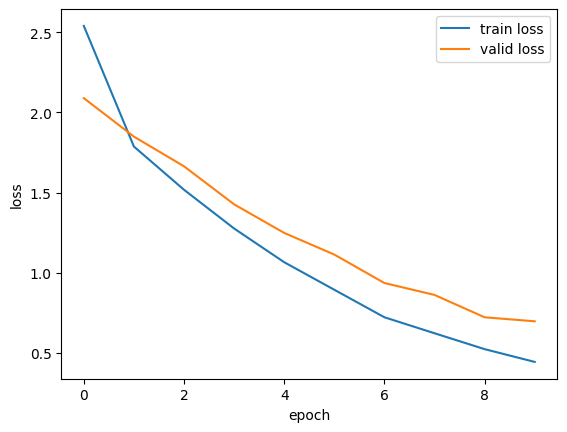

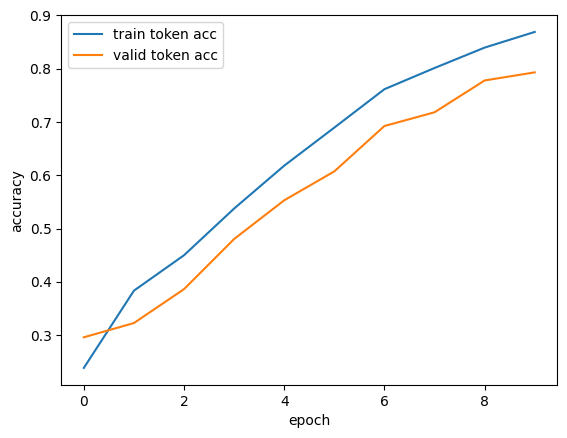

In [11]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label="train token acc")
plt.plot(valid_accs, label="valid token acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()


---

## 11) Inference : décodage greedy (génération)

On génère sans fournir la cible :
- on démarre avec `SOS`
- on choisit à chaque pas le token le plus probable (`argmax`)
- on s'arrête à `EOS` ou à une longueur max

> Note : beam search sera vu plus tard.


In [12]:
@torch.no_grad()
def greedy_decode(model, src_seq, max_len=30):
    model.eval()
    src = torch.tensor([src_seq], dtype=torch.long, device=device)  # [1, Tsrc]
    h, c = model.encoder(src)

    input_tok = torch.tensor([[SOS]], dtype=torch.long, device=device)  # [1,1]
    out_tokens = []
    for _ in range(max_len):
        step_logits, h, c = model.decoder(input_tok, h, c)  # [1,1,V]
        pred_tok = step_logits.argmax(-1)                   # [1,1]
        tok = pred_tok.item()
        out_tokens.append(tok)
        input_tok = pred_tok
        if tok == EOS:
            break
    return out_tokens

# Exemple
ex_src = [1, 5, 7, 3]
pred = greedy_decode(model, ex_src, max_len=20)
print("src :", ex_src)
print("pred:", pred)
print("gold:", list(reversed(ex_src)) + [EOS])


src : [1, 5, 7, 3]
pred: [3, 7, 5, 1, 10, 22]
gold: [3, 7, 5, 1, 22]


---

## 12) Test final


In [13]:
test_loss, test_acc, test_em = evaluate(model, test_loader, criterion)
print(f"TEST | loss {test_loss:.4f} token-acc {test_acc:.3f} exact-match {test_em:.3f}")


TEST | loss 0.6592 token-acc 0.806 exact-match 0.001


---

## 13) Analyse qualitative d’erreurs


In [14]:
def pretty(seq):
    out = []
    for tok in seq:
        if tok == PAD:
            continue
        if tok == SOS:
            continue
        out.append(tok)
    return out

for i in range(10):
    src_seq, tgt_seq = test_ds[i]
    pred = greedy_decode(model, src_seq, max_len=25)
    print(f"[{i}] src  = {src_seq}")
    print(f"    gold = {pretty(tgt_seq)}")
    print(f"    pred = {pretty([SOS] + pred)}")
    print()


[0] src  = [11, 6, 2, 12, 2, 2, 19]
    gold = [19, 2, 2, 12, 2, 6, 11, 22]
    pred = [19, 2, 2, 12, 2, 6, 11, 22]

[1] src  = [3, 3, 20, 15, 4, 11, 17, 1, 17, 12, 4, 3]
    gold = [3, 4, 12, 17, 1, 17, 11, 4, 15, 20, 3, 3, 22]
    pred = [4, 3, 17, 17, 12, 1, 11, 4, 15, 3, 20, 3, 22]

[2] src  = [11, 1, 10, 4]
    gold = [4, 10, 1, 11, 22]
    pred = [4, 10, 1, 11, 10, 22]

[3] src  = [6, 11, 2, 3, 4]
    gold = [4, 3, 2, 11, 6, 22]
    pred = [4, 3, 2, 11, 6, 2, 22]

[4] src  = [17, 15, 11, 2, 17]
    gold = [17, 2, 11, 15, 17, 22]
    pred = [17, 2, 17, 11, 15, 17, 22]

[5] src  = [13, 15, 2, 7, 19]
    gold = [19, 7, 2, 15, 13, 22]
    pred = [19, 7, 2, 15, 13, 2, 22]

[6] src  = [19, 16, 8]
    gold = [8, 16, 19, 22]
    pred = [8, 16, 19, 8, 22]

[7] src  = [1, 15, 20, 19, 4, 10, 20, 8, 16, 4, 20]
    gold = [20, 4, 16, 8, 20, 10, 4, 19, 20, 15, 1, 22]
    pred = [20, 4, 16, 8, 4, 20, 19, 10, 20, 15, 15, 22]

[8] src  = [2, 9, 12, 4]
    gold = [4, 12, 9, 2, 22]
    pred = [4, 1

---

## 14) Bonus : performance vs longueur

Dans un Seq2Seq simple **sans attention**, les performances baissent souvent quand la longueur augmente,
car tout doit être compressé dans l'état final `(h, c)`.

On mesure ici l'**exact match** par longueur.


In [15]:
@torch.no_grad()
def evaluate_by_length(model, n_per_len=300):
    results = {}
    for L in range(MIN_LEN, MAX_LEN+1):
        data = []
        for _ in range(n_per_len):
            src = [random.randint(1, V) for _ in range(L)]
            tgt = [SOS] + list(reversed(src)) + [EOS]
            data.append((src, tgt))

        ems = []
        for i in range(0, len(data), 64):
            batch = data[i:i+64]
            src_seqs = [b[0] for b in batch]
            tgt_seqs = [b[1] for b in batch]

            src, _ = pad_sequences(src_seqs, PAD)
            tgt, _ = pad_sequences(tgt_seqs, PAD)

            tgt_in = tgt[:, :-1]
            tgt_out = tgt[:, 1:]

            src = src.to(device)
            tgt_in = tgt_in.to(device)
            tgt_out = tgt_out.to(device)

            logits = model(src, tgt_in, teacher_forcing_ratio=0.0)
            ems.append(exact_match_accuracy(logits, tgt_out))

        results[L] = float(np.mean(ems))
    return results

length_results = evaluate_by_length(model, n_per_len=300)
length_results


{3: 0.0,
 4: 0.0,
 5: 0.009375,
 6: 0.042045454545454546,
 7: 0.10823863636363637,
 8: 0.19232954545454545,
 9: 0.2778409090909091,
 10: 0.1534090909090909,
 11: 0.06363636363636363,
 12: 0.003125}

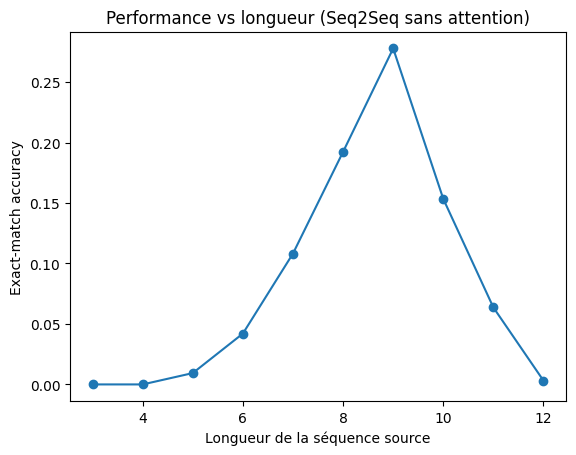

In [16]:
plt.figure()
plt.plot(list(length_results.keys()), list(length_results.values()), marker='o')
plt.xlabel("Longueur de la séquence source")
plt.ylabel("Exact-match accuracy")
plt.title("Performance vs longueur (Seq2Seq sans attention)")
plt.show()


---

## 15) Questions à rendre (rapport 1 page)

1. Expliquez le rôle de `SOS` et `EOS`.  
2. Pourquoi padder ? Pourquoi `ignore_index=PAD` dans la loss ?  
3. Comparez teacher forcing : essayez `TEACHER_FORCING_RATIO=0.0` puis `0.9`.  
4. Décrivez les erreurs quand la longueur augmente.  
5. Proposez une amélioration architecturale (indice : **attention**).

---

## 16) Extensions (facultatif)
- Remplacer LSTM par GRU et comparer.
- Ajouter `pack_padded_sequence` (gestion propre des longueurs).
- Implémenter beam search (T2).
- Implémenter l’attention (T3).
